# Exercício de Transfer Learning (DIO)

**Autor: Gabriel Lacerda Caldi**

Portfólio: https://ikirior.github.io/gabrielcaldi.dev/

---

# Introdução

Este notebook tem como objetivo resolver um desafio proposto em um dos exercícios da trilha de Machine Learning da DIO. O exercício utiliza a técnica de Transfer Learning, onde os parâmetros de um modelo de deep learning previamente treinado são reaproveitados para uma nova tarefa específica. Com esse procedimento, as camadas do modelo treinado (exceto a última) são mantidas congeladas, enquanto a última camada é treinada com as novas imagens. Esse processo reduz o tempo de aprendizado e, consequentemente, o custo computacional.

## O que é Transfer Learning?

No Transfer Learning, o modelo pré-treinado já possui uma compreensão básica sobre o mundo (como reconhecer formas e padrões em imagens). Ao aplicar esse modelo a um novo problema, as camadas iniciais são mantidas e apenas a parte final do modelo é ajustada para o novo conjunto de dados. Esse processo torna o treinamento mais rápido e eficiente, especialmente quando se tem um número limitado de dados rotulados para a nova tarefa.

## Exemplo Baseado no Keras

Como exemplo, foi seguida a estrutura de um exercício em Keras para Transfer Learning, disponível [aqui](https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb#scrollTo=rFL-fLitYoa3).

A partir desse exemplo, foi dividido o processo em 9 etapas para o tratamento de dados, treinamento e validação do modelo.

## Modelo Utilizado: VGG16

O modelo pré-treinado utilizado neste exercício foi o VGG16 da Keras. Este modelo foi treinado originalmente em uma base de dados contendo mais de 1 milhão de imagens. Ele é um exemplo de rede neural convolucional profunda (CNN), utilizado para para tarefas de classificação de imagens.

## Descrição do Modelo VGG16

Segue a tabela de descrição do modelo abaixo:

| Model  | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | Time (ms) per inference step (CPU) | Time (ms) per inference step (GPU) |
|--------|-----------|-----------------|----------------|------------|-------|------------------------------------|------------------------------------|
| VGG16  | 528       | 71.3%           | 90.1%          | 138.4M     | 16    | 69.5                               | 4.2                                |

## Dataset Utilizado

O conjunto de imagens utilizadas para o treinamento do modelo foi o Cats vs Dogs, que possui 25 mil imagens, sendo elas divididas igualmente para o treinamento de categorização da classe gato e classe cachorro.

O dataset pode ser encontrado [aqui](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

## Importação

Importação das bibliotecas e funções necessárias para o exercício, e também, a extração das pastas com as imagens para o treinamento.


In [ ]:
%matplotlib inline

import os

import numpy as np # Biblioteca para cálculos de arranjos e matrizes multidimensionais.
import keras # Biblioteca para construção de redes neurais, que possui o TensorFlow como backend.
import zipfile # Biblioteca para manipulação e extração de arquivos zip
import tensorflow as tf # Biblioteca para aprendizado de máquina e computação numérica.
from PIL import Image # Biblioteca de tratamento de imagens

import matplotlib.pyplot as plt # biblioteca de visualização gráfica
from matplotlib.pyplot import imshow

# Imports de funções do Keras e do Tensorflow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from google.colab import drive # Montagem do drive com o arquivo com as imagens
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/Training/cats_and_dogs.zip'
extract_path = '/content/PetImages'

with zipfile.ZipFile(zip_path, 'r') as zip_ref: # Extração das pastas com as imagens de cachorro e gato
    zip_ref.extractall(extract_path)

train_dir = '/content/PetImages/PetImages'

## Tratamento de Dados

No primeiro treinamento feito com o modelo, foram observados alguns erros que indicavam uma dificuldade na leitura do dataset, algo que passou desapercebido inicialmente.

Verificando as pastas com as imagens, foram identificados dois arquivos chamados Thumbs.db, respectivamente. Estes estavam causando erros durante a leitura por não serem imagens. Então o bloco de código a seguir foi implementado para percorrer todas as pastas do diretório de treinamento e verificar se existem arquivos que não conseguirão ser lidos pelo modelo. Caso encontrados, eles são removidos e o dataset passa a ser composto somente por imagens.

In [ ]:
def remove_invalid_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verifica se a imagem está corrompida
            except (IOError, SyntaxError):
                print(f"Removendo imagem inválida: {file_path}")
                os.remove(file_path)

remove_invalid_images(train_dir)

Removendo imagem inválida: /content/PetImages/PetImages/Cat/Thumbs.db
Removendo imagem inválida: /content/PetImages/PetImages/Cat/666.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removendo imagem inválida: /content/PetImages/PetImages/Dog/Thumbs.db
Removendo imagem inválida: /content/PetImages/PetImages/Dog/11702.jpg


## Conversão e segmentação do conjunto de dados

Com o tratamento concluído, o conjunto de imagens foi pré-processado, passando por um processo de augmentação e depois segmentado em dois conjuntos, sendo eles os conjuntos de treinamento, contendo grande parte das imagens e um conjunto de validação, que será usado para definir a acurácia do modelo.

In [ ]:
image_size = (224, 224)
batch_size = 32

# Gerador de imagens padronizadas
datagen_train = ImageDataGenerator(
    rescale=1.0/255, # Reduz o valor da escala da imagem por 255 pixels (normalização), retornando valores que variam de 0 a 1.
    shear_range=0.2, # Realiza uma transformação de cisalhamento na imagem (shearing) que pode ser feita até 20%
    zoom_range=0.2, # Aplica zoom aleatório nas imagens. O valor de 0.2 indica que o zoom pode variar de 80% até 120%
    horizontal_flip=True, # Permite que o Keras gere imagens espelhadas horizontalmente
    validation_split=0.2,  # Define 20% do conjunto de dados para validação
    preprocessing_function=preprocess_input  # Aplica a função de pré-processamento especificada para o modelo escolhido
)

# Gerador de imagens para o treino
train_generator = datagen_train.flow_from_directory(
    train_dir, # Especifica o caminho para o diretório onde estão localizadas as imagens de treinamento
    target_size=image_size, # Redimensiona a imagem para um tamanho padronizado
    batch_size=batch_size, # Numero de imagens a serem processadas por vez
    class_mode='binary', # Modo de classe que rotula as imagens com valores 0 ou 1 dependendo da característica
    subset='training'  # Especifica que esse geraor será usado para o conjunto de treinamento
)

# Gerador de imagens para a validação
val_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Especifica que esse geraor será usado para o conjunto de validação
)

# Carrega o modelo de rede neural convolucional previamente treinado com o pesos de treino da biblioteca Imagenet
vgg = VGG16(weights="imagenet",
            include_top=False, # Indica que a última camada (responsável pela classificação) não será carregada
            input_shape=(224, 224, 3)
            )

# Exibe um sumário de todas as camadas do modelo e seus parâmetros
vgg.summary()

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Verificação dos Rótulos do Dataset

Durante o processo de treinamento, foi identificado um valor anômalo no cálculo do loss (erro médio), que estava retornando valores fixos de 0.000000e+00. Esse resultado é incoerente, pois em algoritmos de aprendizado de máquina, que se baseiam em métodos heurísticos e probabilísticos, é improvável que o erro seja exatamente zero, especialmente em datasets com variabilidade.

Esse comportamento pode indicar problemas como:

- Dados inconsistentes ou mal formatados.
- Labels incorretamente atribuídos às imagens.
- Parâmetros de entrada não compatíveis com o modelo VGG16, como dimensões ou - valores fora do intervalo esperado.

O bloco abaixo foi adicionado para verificar a conformidade das imagens e rótulos após a etapa de pré-processamento, excluindo a possibilidade dos possíveis erros acima:

In [ ]:
x_batch, y_batch = next(train_generator)
print("Shape das imagens:", x_batch.shape)
print("Labels:", y_batch)

Shape das imagens: (32, 224, 224, 3)
Labels: [0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0.]


A consistência dessa saída confirma que o pré-processamento dos dados foi feito corretamente e não há erros na atribuição de rótulos ou na formatação das imagens.

## Construção e Compilação do Modelo

Etapa de obtenção das entradas e saídas, definição e compilação do novo modelo a ser treinado e a saída a ser retornada por ele.

In [ ]:
inp = vgg.input # Obtém a entrada do modelo VGG16, que espera inputs de imagens de tamanho (224, 224, 3).

x = vgg.output # Obtém a saída do modelo pré treinado, que consiste em um mapa de características (feature maps).
x = GlobalAveragePooling2D()(x) # Reduz cada mapa de características do modelo em um único valor médio, diminuindo o overfitting e a dimensionalidade da saída.
x = Dense(128, activation='relu')(x) # Adiciona uma camada densa com 128 neurônios com a função de ativação ReLu, que introduz não-lineariedade ao modelo.
x = Dense(1, activation='sigmoid')(x) # Adiciona uma camada final com 1 neurônio com ativação sigmoide. Ela é adequada para classificações binárias, retornando valores entre 0 e 1.

model_new = Model(inputs=vgg.input, outputs=x) # Define o novo modelo com as camadas do VGG16 treinado anteriormente e com as novas camadas para a classificação binária.

for layer in vgg.layers:
    layer.trainable = False # Função para travar as camadas treinadas anteriormente, reduzindo o tempo de aprendizado.

model_new.compile(loss='binary_crossentropy', # Função de perda (erro médio) de classificação binária.
                  optimizer='adam', # Otimmizador eficiente para redes neurais.
                  metrics=['accuracy'] # Avalia o desempenho do modelo com base na precisão.
                  )

model_new.summary() # Exibe um sumário contendo as camadas da nova rede neural convolucional.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Na imagem abaixo é possível observar a diferença entre as últimas camadas do modelo padrão treinado com imagens da ImageNet com 14.714.688 milhões de parâmetros treináveis, e as últimas camadas do novo modelo com 65.793 mil parâmetros treinaveis e o restante congelados.

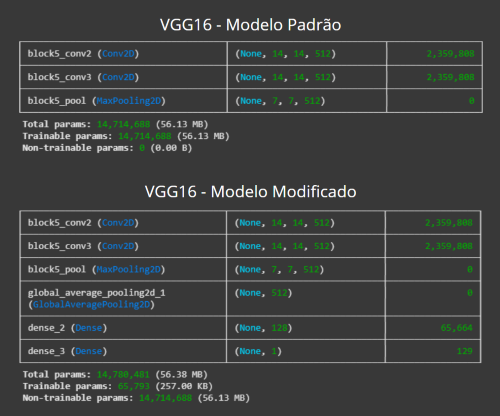

## Treinamento do Modelo

Durante esta etapa o modelo é treinado com os inputs das imagens dos geradores, retornando em cada uma das n épocas (epochs) especificadas na função os valores de: acurácia (taxa de acerto do modelo) e erro médio para os datasets de treino e de validação.

Observações:

- O modelo foi limitado a 10 épocas e 50 etapas por época por um limite de tempo de processamento com a utilização das GPUs do Google Colab. Durante o treinamento inicial foi observado que o tempo de treinamento com o ambiente padrão de execução com CPUs levava em média uma hora e meia para terminar, enquanto utilizando as unidades de processamento gráfico o tempo total utilizado foi de 15 minutos, ou seja, uma diminuição em cerca de 83,33% em relação ao uso de processamento sem GPU dedicada.

In [ ]:
steps_per_epoch = len(train_generator) # Lê o tamanho do gerador de imagens  (batches) para treino
validation_steps = len(val_generator) # Lê o tamanho do gerador de imagens (batches) para validação

history = model_new.fit(
    train_generator, # Gerador de rótulos de treino
    epochs=10, # O modelo será limitado a 10 épocas, onde uma época é a passagem completa por todos os dados de treino
    steps_per_epoch=50, # O modelo sará limitado a 50 épocas
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8794 - loss: 0.3219 - val_accuracy: 0.8936 - val_loss: 0.2824
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8917 - loss: 0.2822 - val_accuracy: 0.9036 - val_loss: 0.2533
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9145 - loss: 0.2433 - val_accuracy: 0.9072 - val_loss: 0.2357
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9162 - loss: 0.2191 - val_accuracy: 0.8954 - val_loss: 0.2529
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9122 - loss: 0.2176 - val_accuracy: 0.9204 - val_loss: 0.2058
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9015 - loss: 0.2354 - val_accuracy: 0.9130 - val_loss: 0.2138
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9054 - loss: 0.2299 - val_accuracy: 0.9206 - val_loss: 0.1993
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9180 - loss: 0.1945 - val_accuracy: 0.9198 - val_loss

## Avaliação Gráfica

Os gráficos abaixos exibem a relação do erro erro médio e a acurácia em relação ao número de épocas no conjunto de dados de validação.

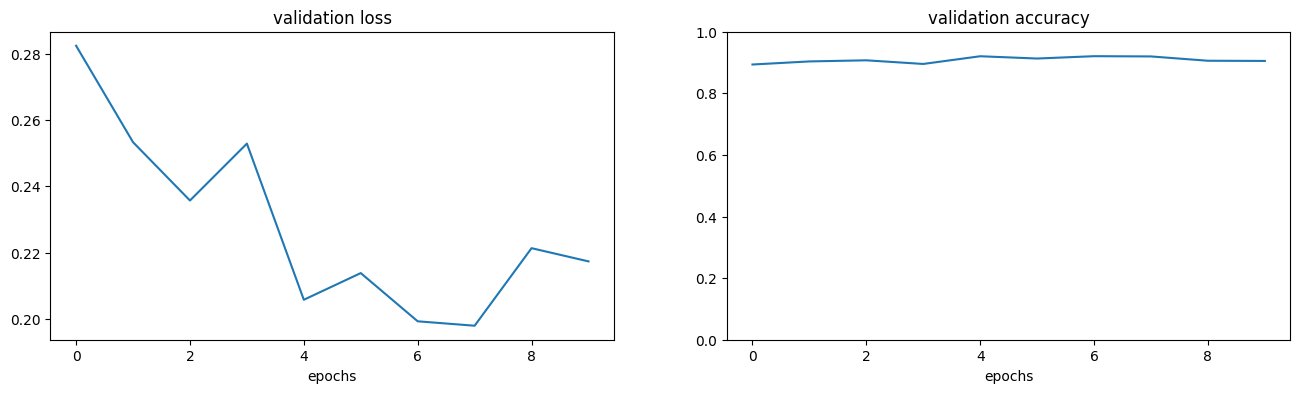

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

## Avaliação Final do Modelo

In [ ]:
loss, accuracy = model_new.evaluate(train_generator, verbose=0) # Etapa de validação final para obter os valores de acurácia e erro médio do modelo
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.21347741782665253
Test accuracy: 0.9083999991416931


Com base nos dados obtidos no treinamento e na etapa de avaliação final do modelo, foram obtidos valores de erro e acurácia válidos para um modelo como este. Isso indica que grande parte das classificações que o modelo fizer 90% será uma classificação correta.

## Funções de Conversão e Classificação de Imagens com Testes Práticos

Para normalizar as imagens de teste em um formato que o algoritmo entenda, e depois classifica-la com uma dos rótulos, foram criadas as funções definidas abaixo:

In [ ]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalizar para o intervalo [0, 1] em um array NumPy
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão do batch (forma exigida pelo TensorFlow/Keras)
    return img_array

In [ ]:
def classify_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array) # Faz a previsão usando o modelo treinado, gerando uma probabilidade para a classe positiva.

    # Lógica para rotular a classe
    class_label = "Cachorro" if prediction >= 0.5 else "Gato"
    confidence = prediction[0][0] if prediction >= 0.5 else 1 - prediction[0][0]

    print(f"Classe: {class_label} (Confiança: {confidence * 100:.2f}%)")

### Teste 1 - Gato

Utilizando o modelo treinado para categorizar a imagem cattest.jpg como gato ou cachorro.

Imagem retirada de: https://www.fatosdesconhecidos.com.br/7-coisas-que-os-gatos-fazem-para-se-comunicar-com-os-humanos/

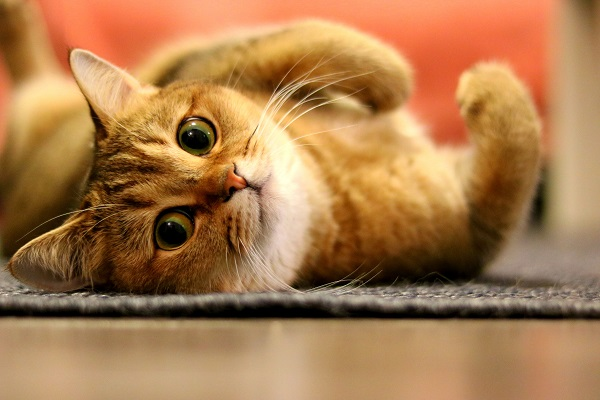

In [ ]:
img_path = "cattest.jpg"
classify_image(model_new, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classe: Gato (Confiança: 99.85%)


### Teste 1 - Cachorro

Utilizando o modelo treinado para categorizar a imagem dogtest.jpg como gato ou cachorro.

Imagem retirada de: https://www.akc.org/expert-advice/lifestyle/7-akc-dog-breed-groups-explained/

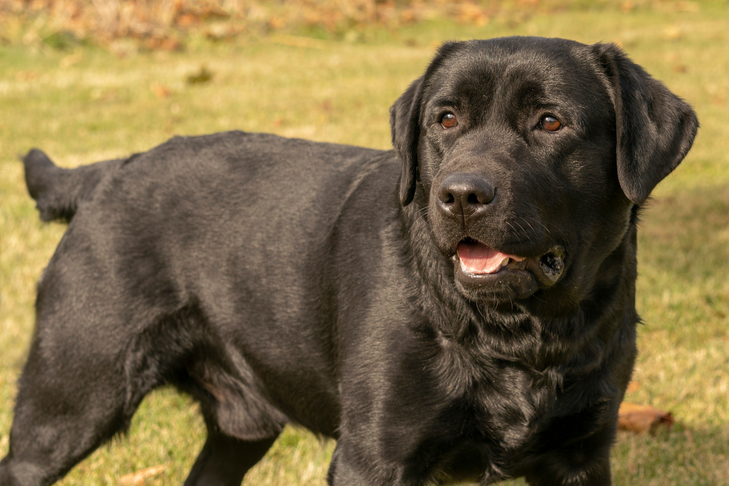

In [ ]:
img_path = "dogtest.jpg"
classify_image(model_new, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Classe: Cachorro (Confiança: 99.18%)


### Teste 2 - Gato

Utilizando o modelo treinado para categorizar a imagem cattest.jpg como gato ou cachorro.

Imagem retirada de: https://unsplash.com/pt-br/s/fotografias/%23cat

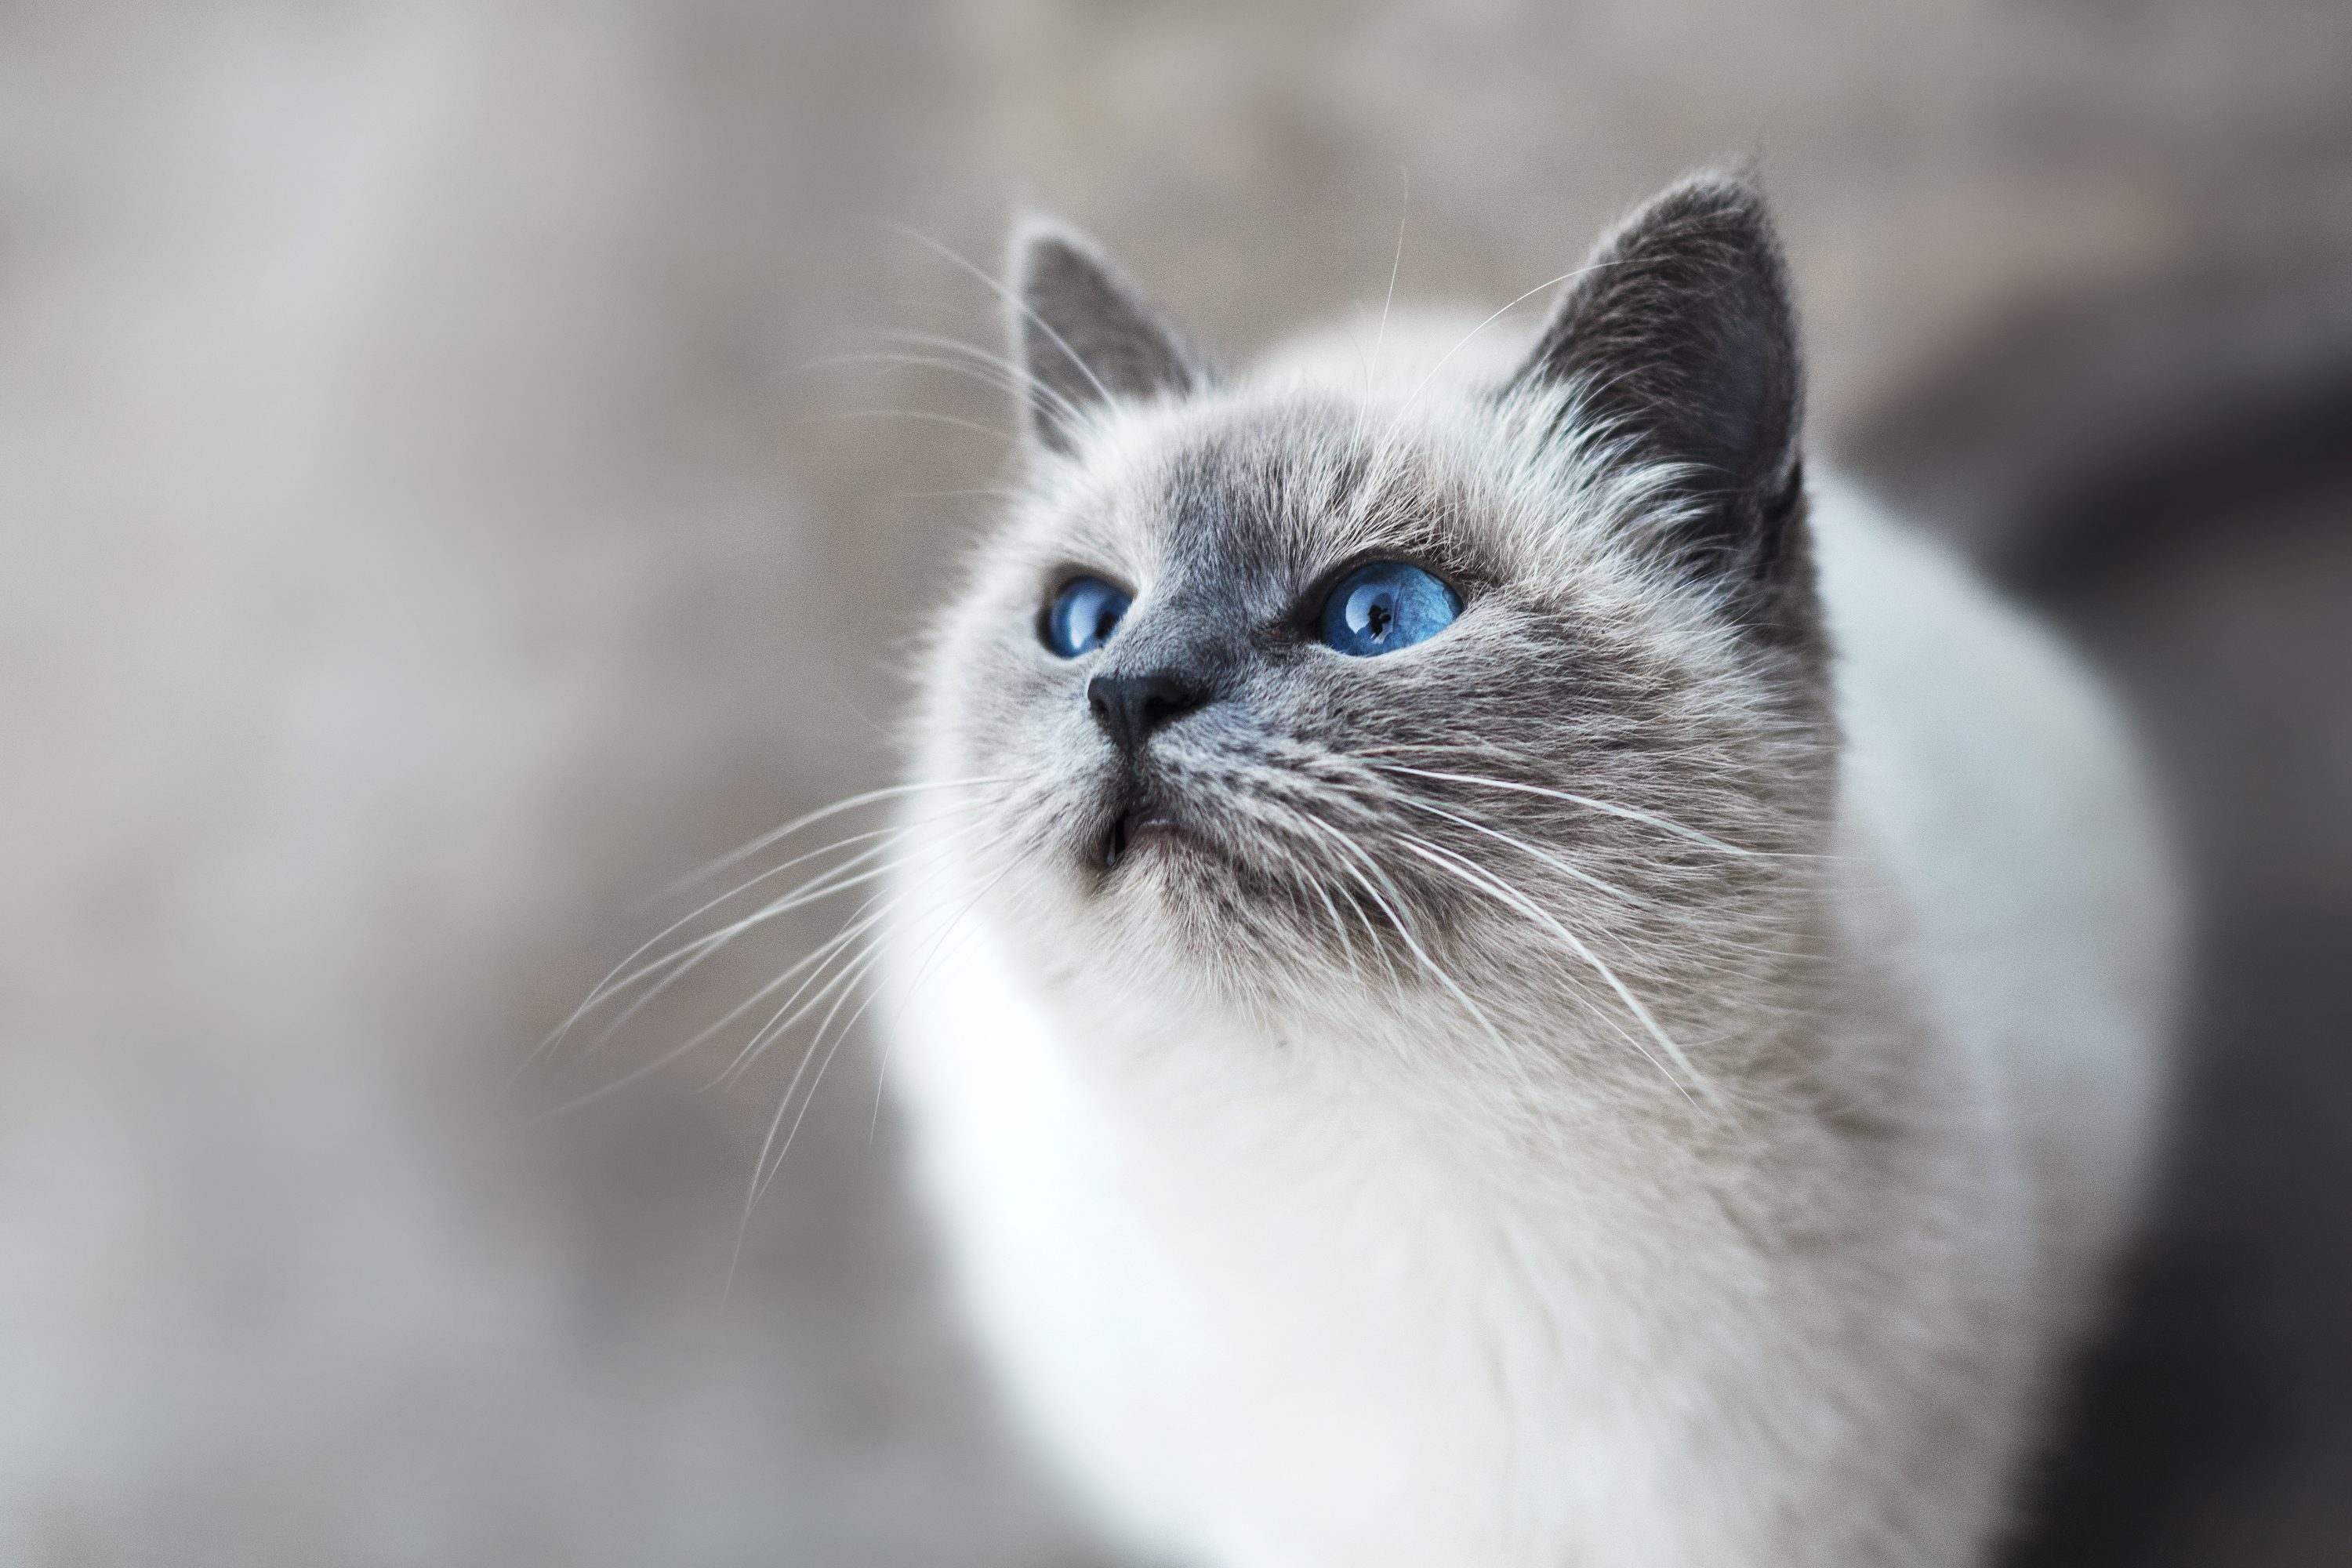

In [ ]:
img_path = "cattest2.jpg"
classify_image(model_new, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Classe: Gato (Confiança: 99.95%)


### Teste 2 - Cachorro

Utilizando o modelo treinado para categorizar a imagem dogtest2.jpg como gato ou cachorro.

Imagem retirada de: https://www.rspca.org.uk/adviceandwelfare/pets/dogs

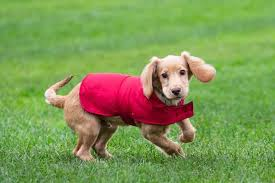

In [ ]:
img_path = "dogtest2.jpg"
classify_image(model_new, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Classe: Cachorro (Confiança: 100.00%)


### Teste 3 - Gato

Utilizando o modelo treinado para categorizar a imagem dogtest2.jpg como gato ou cachorro.

Imagem retirada de: https://br.pinterest.com/pin/106960559889837677/

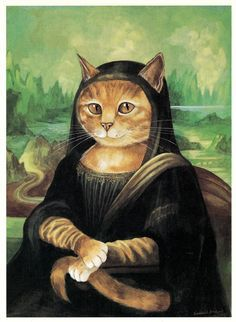

In [ ]:
img_path = "cattest3.jpg"
classify_image(model_new, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Classe: Gato (Confiança: 92.06%)


### Teste 3 - Cachorro

Utilizando o modelo trainado para categorizar a imagem dogtest3.jpg como gato ou cachorro.

Imagem retirada de: https://timesofindia.indiatimes.com/life-style/relationships/web-stories/8-large-and-friendly-pet-dog-breeds-in-the-world/photostory/114390012.cms

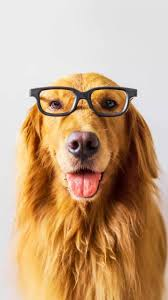

In [ ]:
img_path = "dogtest3.jpg"
classify_image(model_new, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Classe: Cachorro (Confiança: 97.42%)
